Epoch 1/100 - accuracy: 0.9146 - loss: 0.2524 - val_accuracy: 0.9176 - val_loss: 0.2469
Epoch 2/100 - accuracy: 0.9589 - loss: 0.1273 - val_accuracy: 0.9601 - val_loss: 0.1273
Epoch 3/100 - accuracy: 0.9605 - loss: 0.1160 - val_accuracy: 0.9614 - val_loss: 0.1167
Epoch 4/100 - accuracy: 0.9608 - loss: 0.1140 - val_accuracy: 0.9606 - val_loss: 0.1150
Epoch 5/100 - accuracy: 0.9606 - loss: 0.1134 - val_accuracy: 0.9608 - val_loss: 0.1146
Epoch 6/100 - accuracy: 0.9606 - loss: 0.1132 - val_accuracy: 0.9606 - val_loss: 0.1144
Epoch 7/100 - accuracy: 0.9606 - loss: 0.1131 - val_accuracy: 0.9605 - val_loss: 0.1144
Epoch 8/100 - accuracy: 0.9607 - loss: 0.1130 - val_accuracy: 0.9603 - val_loss: 0.1143
Epoch 9/100 - accuracy: 0.9607 - loss: 0.1130 - val_accuracy: 0.9604 - val_loss: 0.1143
Epoch 10/100 - accuracy: 0.9607 - loss: 0.1129 - val_accuracy: 0.9603 - val_loss: 0.1143
Epoch 11/100 - accuracy: 0.9607 - loss: 0.1129 - val_accuracy: 0.9603 - val_loss: 0.1142
Epoch 12/100 - accuracy: 0.960

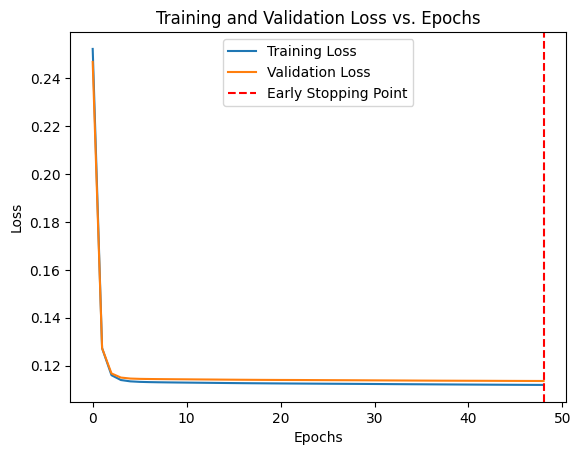

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Load the dataset
dataset = pd.read_csv('/content/diabetes_prediction_dataset.csv')

# Convert categorical variables into 'dummy' or indicator variables
dataset['gender'] = dataset['gender'].astype('category')
dataset['smoking_history'] = dataset['smoking_history'].astype('category')

# Handle categorical features
gender_dummies = pd.get_dummies(dataset['gender'], drop_first=True)
smoking_dummies = pd.get_dummies(dataset['smoking_history'], drop_first=True)

# Add new dummy columns to the dataset
dataset = pd.concat([dataset, gender_dummies, smoking_dummies], axis=1)

# Drop original categorical columns
dataset.drop(['gender', 'smoking_history'], axis=1, inplace=True)

# Define features and target variable
x = dataset.drop('diabetes', axis=1).values  # Features as NumPy array
y = dataset['diabetes'].values.reshape(-1, 1)  # Target as a column vector

# Scale the data
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Split the data into training, validation, and testing sets
x_train, x_rem, y_train, y_rem = train_test_split(x_scaled, y, test_size=0.25, random_state=101)
x_val, x_test, y_val, y_test = train_test_split(x_rem, y_rem, test_size=0.50, random_state=101)

# Initialize weights and biases
np.random.seed(101)  # For reproducibility
weights_hidden = np.random.randn(x_train.shape[1], 32) * 0.01  # Hidden layer weights
bias_hidden = np.zeros((1, 32))  # Hidden layer biases
weights_output = np.random.randn(32, 1) * 0.01  # Output layer weights
bias_output = np.zeros((1, 1))  # Output layer biases

# Hyperparameters
learning_rate = 0.01
epochs = 100
batch_size = 32
patience = 8

# Activation functions and their derivatives
def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Cost function
def compute_cost(y_true, y_pred):
    m = y_true.shape[0]
    return -1/m * np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

# Early stopping variables
best_val_loss = float('inf')
patience_counter = 0
min_delta = 1e-4  # Minimum improvement threshold
early_stopping_epoch = None

# Training loop with updated early stopping
history = {"loss": [], "val_loss": [], "accuracy": [], "val_accuracy": []}
for epoch in range(epochs):
    # Mini-batch gradient descent
    for i in range(0, x_train.shape[0], batch_size):
        x_batch = x_train[i:i+batch_size]
        y_batch = y_train[i:i+batch_size]

        # Forward pass
        z_hidden = np.dot(x_batch, weights_hidden) + bias_hidden
        a_hidden = relu(z_hidden)
        z_output = np.dot(a_hidden, weights_output) + bias_output
        a_output = sigmoid(z_output)

        # Compute gradients
        m_batch = y_batch.shape[0]
        dz_output = a_output - y_batch
        dw_output = np.dot(a_hidden.T, dz_output) / m_batch
        db_output = np.sum(dz_output, axis=0, keepdims=True) / m_batch

        dz_hidden = np.dot(dz_output, weights_output.T) * relu_derivative(z_hidden)
        dw_hidden = np.dot(x_batch.T, dz_hidden) / m_batch
        db_hidden = np.sum(dz_hidden, axis=0, keepdims=True) / m_batch

        # Update weights and biases
        weights_output -= learning_rate * dw_output
        bias_output -= learning_rate * db_output
        weights_hidden -= learning_rate * dw_hidden
        bias_hidden -= learning_rate * db_hidden

    # Compute training loss and accuracy
    z_hidden_train = np.dot(x_train, weights_hidden) + bias_hidden
    a_hidden_train = relu(z_hidden_train)
    z_output_train = np.dot(a_hidden_train, weights_output) + bias_output
    a_output_train = sigmoid(z_output_train)
    train_loss = compute_cost(y_train, a_output_train)
    train_accuracy = np.mean((a_output_train > 0.5) == y_train)
    history["loss"].append(train_loss)
    history["accuracy"].append(train_accuracy)

    # Compute validation loss and accuracy
    z_hidden_val = np.dot(x_val, weights_hidden) + bias_hidden
    a_hidden_val = relu(z_hidden_val)
    z_output_val = np.dot(a_hidden_val, weights_output) + bias_output
    a_output_val = sigmoid(z_output_val)
    val_loss = compute_cost(y_val, a_output_val)
    val_accuracy = np.mean((a_output_val > 0.5) == y_val)
    history["val_loss"].append(val_loss)
    history["val_accuracy"].append(val_accuracy)

    # Early stopping logic with minimum delta
    if best_val_loss - val_loss > min_delta:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            early_stopping_epoch = epoch + 1  # Epochs start from 1
            break

    # Print progress every epoch
    print(f"Epoch {epoch + 1}/{epochs} - accuracy: {train_accuracy:.4f} - loss: {train_loss:.4f} - val_accuracy: {val_accuracy:.4f} - val_loss: {val_loss:.4f}")

# Testing
z_hidden_test = np.dot(x_test, weights_hidden) + bias_hidden
a_hidden_test = relu(z_hidden_test)
z_output_test = np.dot(a_hidden_test, weights_output) + bias_output
a_output_test = sigmoid(z_output_test)
y_test_pred = (a_output_test > 0.5).astype(int)

# Compute test loss and accuracy
test_loss = compute_cost(y_test, a_output_test)
test_accuracy = np.mean((a_output_test > 0.5) == y_test)
print(f"\nTest loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# Plot Training and Validation Loss
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
if early_stopping_epoch is not None:
    plt.axvline(x=early_stopping_epoch - 1, color='r', linestyle='--', label='Early Stopping Point')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss vs. Epochs")
plt.legend()
plt.show()